In [143]:
pip install pyspark

In [144]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

In [145]:
# Create a Spark session
spark = SparkSession.builder.appName("ImprovedStockPrediction").getOrCreate()

In [146]:
# Load the data from the CSV into a DataFrame
df = spark.read.csv("/content/indexProcessed.csv", header=True, inferSchema=True)

In [147]:
df.show()

+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+
|Index|      Date|       Open|       High|        Low|      Close|  Adj Close|Volume|          CloseUSD|
+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+
|  HSI|1986-12-31|2568.300049|2568.300049|2568.300049|2568.300049|2568.300049|   0.0|      333.87900637|
|  HSI|1987-01-02|2540.100098|2540.100098|2540.100098|2540.100098|2540.100098|   0.0|      330.21301274|
|  HSI|1987-01-05|2552.399902|2552.399902|2552.399902|2552.399902|2552.399902|   0.0|      331.81198726|
|  HSI|1987-01-06|2583.899902|2583.899902|2583.899902|2583.899902|2583.899902|   0.0|335.90698726000005|
|  HSI|1987-01-07|2607.100098|2607.100098|2607.100098|2607.100098|2607.100098|   0.0|      338.92301274|
|  HSI|1987-01-08|2603.300049|2603.300049|2603.300049|2603.300049|2603.300049|   0.0|      338.42900637|
|  HSI|1987-01-09|2561.699951|2561.699951|2561.699951|2

In [148]:
df.count()

104224

In [149]:
len(df.columns)

9

In [150]:
df.printSchema()

root
 |-- Index: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- CloseUSD: double (nullable = true)



In [151]:
type(df)

pyspark.sql.dataframe.DataFrame

In [152]:
df.head(5)

[Row(Index='HSI', Date=datetime.date(1986, 12, 31), Open=2568.300049, High=2568.300049, Low=2568.300049, Close=2568.300049, Adj Close=2568.300049, Volume=0.0, CloseUSD=333.87900637),
 Row(Index='HSI', Date=datetime.date(1987, 1, 2), Open=2540.100098, High=2540.100098, Low=2540.100098, Close=2540.100098, Adj Close=2540.100098, Volume=0.0, CloseUSD=330.21301274),
 Row(Index='HSI', Date=datetime.date(1987, 1, 5), Open=2552.399902, High=2552.399902, Low=2552.399902, Close=2552.399902, Adj Close=2552.399902, Volume=0.0, CloseUSD=331.81198726),
 Row(Index='HSI', Date=datetime.date(1987, 1, 6), Open=2583.899902, High=2583.899902, Low=2583.899902, Close=2583.899902, Adj Close=2583.899902, Volume=0.0, CloseUSD=335.90698726000005),
 Row(Index='HSI', Date=datetime.date(1987, 1, 7), Open=2607.100098, High=2607.100098, Low=2607.100098, Close=2607.100098, Adj Close=2607.100098, Volume=0.0, CloseUSD=338.92301274)]

In [153]:
df.dtypes

[('Index', 'string'),
 ('Date', 'date'),
 ('Open', 'double'),
 ('High', 'double'),
 ('Low', 'double'),
 ('Close', 'double'),
 ('Adj Close', 'double'),
 ('Volume', 'double'),
 ('CloseUSD', 'double')]

In [154]:
df.describe().show()

+-------+---------+-----------------+------------------+-----------------+-----------------+-----------------+--------------------+------------------+
|summary|    Index|             Open|              High|              Low|            Close|        Adj Close|              Volume|          CloseUSD|
+-------+---------+-----------------+------------------+-----------------+-----------------+-----------------+--------------------+------------------+
|  count|   104224|           104224|            104224|           104224|           104224|           104224|              104224|            104224|
|   mean|     NULL|8015.353333862647|8063.3242344383625|7962.581120341013|8014.366642221978|8014.161269268126|1.3476460022580404E9| 3046.729177469137|
| stddev|     NULL|9140.563403756769| 9196.575802122532|9082.767801531907|9140.609757679405|9140.720455503126| 4.427662036698373E9| 3747.865623003096|
|    min|000001.SS|        54.869999|         54.869999|        54.869999|        54.869999|  

# Feature Engineering

In [155]:
# Window function to order by date (for features that require looking at previous rows)
w = Window.partitionBy().orderBy("date")

In [156]:
# 1. Create a lagged column for the 'close' price (i.e., previous day's close)
df = df.withColumn("lag_close_1", F.lag(df.Close).over(w))

In [157]:
df.show(5)

+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+
|Index|      Date|       Open|       High|        Low|      Close|  Adj Close|Volume|          CloseUSD|lag_close_1|
+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+
| N225|1965-01-05|1257.719971|1257.719971|1257.719971|1257.719971|1257.719971|   0.0|       12.57719971|       NULL|
| N225|1965-01-06| 1263.98999| 1263.98999| 1263.98999| 1263.98999| 1263.98999|   0.0|12.639899900000001|1257.719971|
| N225|1965-01-07| 1274.27002| 1274.27002| 1274.27002| 1274.27002| 1274.27002|   0.0|        12.7427002| 1263.98999|
| N225|1965-01-08|1286.430054|1286.430054|1286.430054|1286.430054|1286.430054|   0.0|       12.86430054| 1274.27002|
| N225|1965-01-12|1288.540039|1288.540039|1288.540039|1288.540039|1288.540039|   0.0|12.885400390000001|1286.430054|
+-----+----------+-----------+-----------+-----------+----------

In [158]:
# 2. Calculate daily return - how much did the price change in percentage from opening to closing
df = df.withColumn("daily_return", (df.Close - df.Open) / df.Open)

In [159]:
df.show(5)

+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+
|Index|      Date|       Open|       High|        Low|      Close|  Adj Close|Volume|          CloseUSD|lag_close_1|daily_return|
+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+
| N225|1965-01-05|1257.719971|1257.719971|1257.719971|1257.719971|1257.719971|   0.0|       12.57719971|       NULL|         0.0|
| N225|1965-01-06| 1263.98999| 1263.98999| 1263.98999| 1263.98999| 1263.98999|   0.0|12.639899900000001|1257.719971|         0.0|
| N225|1965-01-07| 1274.27002| 1274.27002| 1274.27002| 1274.27002| 1274.27002|   0.0|        12.7427002| 1263.98999|         0.0|
| N225|1965-01-08|1286.430054|1286.430054|1286.430054|1286.430054|1286.430054|   0.0|       12.86430054| 1274.27002|         0.0|
| N225|1965-01-12|1288.540039|1288.540039|1288.540039|1288.540039|1288.540039|   0.0|12.88

In [160]:
# 3. Calculate intra-day volatility - difference between the highest and lowest prices of the day
df = df.withColumn("intra_day_volatility", df.High - df.Low)

In [161]:
df.show(5)

+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+--------------------+
|Index|      Date|       Open|       High|        Low|      Close|  Adj Close|Volume|          CloseUSD|lag_close_1|daily_return|intra_day_volatility|
+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+--------------------+
| N225|1965-01-05|1257.719971|1257.719971|1257.719971|1257.719971|1257.719971|   0.0|       12.57719971|       NULL|         0.0|                 0.0|
| N225|1965-01-06| 1263.98999| 1263.98999| 1263.98999| 1263.98999| 1263.98999|   0.0|12.639899900000001|1257.719971|         0.0|                 0.0|
| N225|1965-01-07| 1274.27002| 1274.27002| 1274.27002| 1274.27002| 1274.27002|   0.0|        12.7427002| 1263.98999|         0.0|                 0.0|
| N225|1965-01-08|1286.430054|1286.430054|1286.430054|1286.430054|1286.430054|   0.0|       12

In [162]:
# 4. Calculate daily volatility - change in closing price from the previous day
df = df.withColumn("daily_volatility", df.Close - df.lag_close_1)

In [163]:
df.show(5)

+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+--------------------+------------------+
|Index|      Date|       Open|       High|        Low|      Close|  Adj Close|Volume|          CloseUSD|lag_close_1|daily_return|intra_day_volatility|  daily_volatility|
+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+--------------------+------------------+
| N225|1965-01-05|1257.719971|1257.719971|1257.719971|1257.719971|1257.719971|   0.0|       12.57719971|       NULL|         0.0|                 0.0|              NULL|
| N225|1965-01-06| 1263.98999| 1263.98999| 1263.98999| 1263.98999| 1263.98999|   0.0|12.639899900000001|1257.719971|         0.0|                 0.0|6.2700190000000475|
| N225|1965-01-07| 1274.27002| 1274.27002| 1274.27002| 1274.27002| 1274.27002|   0.0|        12.7427002| 1263.98999|         0.0|                 0.0|

In [164]:
# 5. Calculate a 7-day moving average for the closing prices
df = df.withColumn("7_day_avg_close", F.avg(df.Close).over(w.rowsBetween(-6, 0)))

In [165]:
df.show(5)

+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+--------------------+------------------+------------------+
|Index|      Date|       Open|       High|        Low|      Close|  Adj Close|Volume|          CloseUSD|lag_close_1|daily_return|intra_day_volatility|  daily_volatility|   7_day_avg_close|
+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+--------------------+------------------+------------------+
| N225|1965-01-05|1257.719971|1257.719971|1257.719971|1257.719971|1257.719971|   0.0|       12.57719971|       NULL|         0.0|                 0.0|              NULL|       1257.719971|
| N225|1965-01-06| 1263.98999| 1263.98999| 1263.98999| 1263.98999| 1263.98999|   0.0|12.639899900000001|1257.719971|         0.0|                 0.0|6.2700190000000475|      1260.8549805|
| N225|1965-01-07| 1274.27002| 1274.27002| 1274.27002| 

In [166]:
# Drop any rows with NA values (which might have been introduced due to lagging operations)
df = df.dropna()

In [167]:
df.show(5)

+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+--------------------+------------------+------------------+
|Index|      Date|       Open|       High|        Low|      Close|  Adj Close|Volume|          CloseUSD|lag_close_1|daily_return|intra_day_volatility|  daily_volatility|   7_day_avg_close|
+-----+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+-----------+------------+--------------------+------------------+------------------+
| N225|1965-01-06| 1263.98999| 1263.98999| 1263.98999| 1263.98999| 1263.98999|   0.0|12.639899900000001|1257.719971|         0.0|                 0.0|6.2700190000000475|      1260.8549805|
| N225|1965-01-07| 1274.27002| 1274.27002| 1274.27002| 1274.27002| 1274.27002|   0.0|        12.7427002| 1263.98999|         0.0|                 0.0|10.280029999999897|1265.3266603333334|
| N225|1965-01-08|1286.430054|1286.430054|1286.430054|1

In [168]:
df.count()

104223

In [169]:
len(df.columns)

14

In [170]:
df.printSchema()

root
 |-- Index: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- CloseUSD: double (nullable = true)
 |-- lag_close_1: double (nullable = true)
 |-- daily_return: double (nullable = true)
 |-- intra_day_volatility: double (nullable = true)
 |-- daily_volatility: double (nullable = true)
 |-- 7_day_avg_close: double (nullable = true)



In [171]:
df.describe().show(5)

+-------+---------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+------------------+-----------------+--------------------+--------------------+------------------+------------------+
|summary|    Index|             Open|             High|              Low|            Close|        Adj Close|             Volume|          CloseUSD|      lag_close_1|        daily_return|intra_day_volatility|  daily_volatility|   7_day_avg_close|
+-------+---------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+------------------+-----------------+--------------------+--------------------+------------------+------------------+
|  count|   104223|           104223|           104223|           104223|           104223|           104223|             104223|            104223|           104223|              104223|              104223|            104223|            104223|
|   mean|   

In [172]:
df.dtypes

[('Index', 'string'),
 ('Date', 'date'),
 ('Open', 'double'),
 ('High', 'double'),
 ('Low', 'double'),
 ('Close', 'double'),
 ('Adj Close', 'double'),
 ('Volume', 'double'),
 ('CloseUSD', 'double'),
 ('lag_close_1', 'double'),
 ('daily_return', 'double'),
 ('intra_day_volatility', 'double'),
 ('daily_volatility', 'double'),
 ('7_day_avg_close', 'double')]

# Random Forest Regression

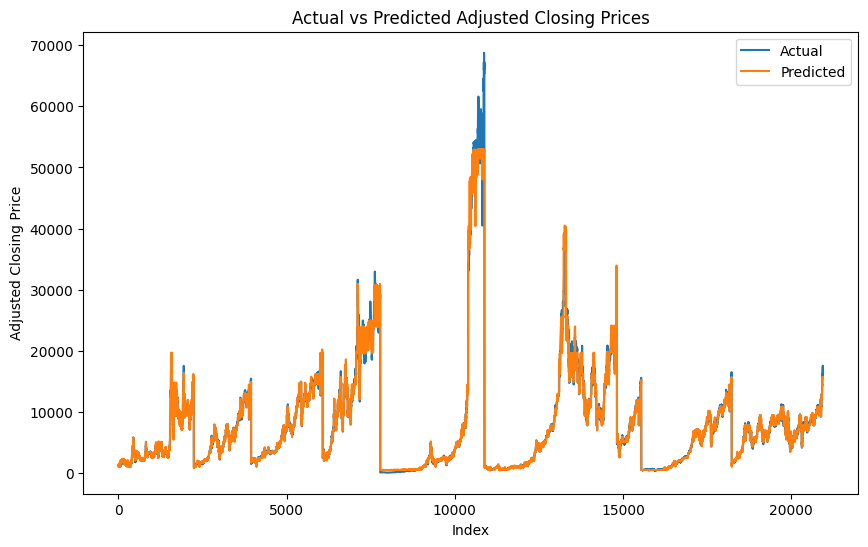

In [173]:
feature_columns = ["Open", "High", "Low", "Close", "Volume", "daily_return",
                   "intra_day_volatility", "daily_volatility", "7_day_avg_close"]
target_col = 'Adj Close'

# Create feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(df)

# Split data into train and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest Regression model
rf = RandomForestRegressor(featuresCol='features', labelCol=target_col)
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Select actual and predicted values for visualization
actual_predicted = predictions.select(['Adj Close', 'prediction'])

# Convert DataFrame to Pandas for plotting
actual_predicted_pd = actual_predicted.toPandas()

# Plot Actual vs Predicted Adjusted Closing Prices
plt.figure(figsize=(10, 6))
plt.plot(actual_predicted_pd['Adj Close'], label='Actual')
plt.plot(actual_predicted_pd['prediction'], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Adjusted Closing Price')
plt.title('Actual vs Predicted Adjusted Closing Prices')
plt.legend()
plt.show()

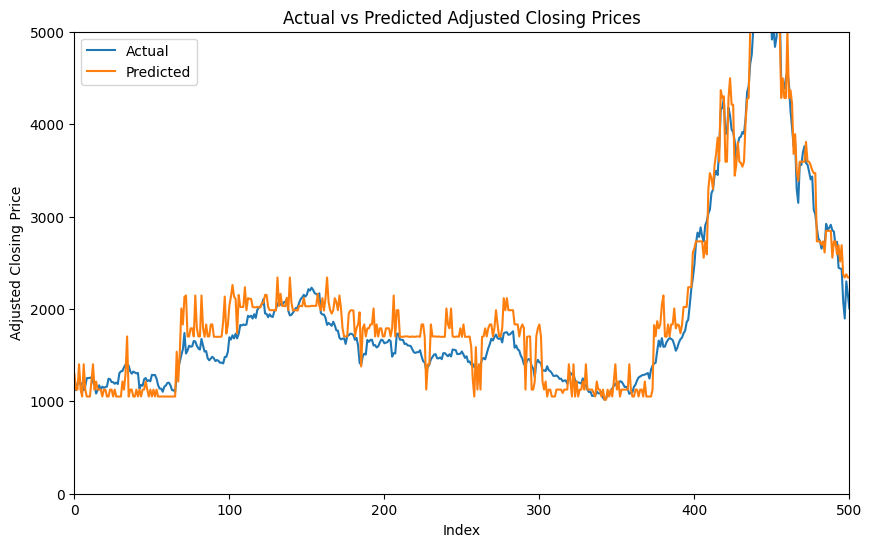

In [174]:
# Plot Actual vs Predicted Prices
actual = predictions.select("Adj Close").collect()
predicted = predictions.select("prediction").collect()

plt.figure(figsize=(10, 6))
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.xlabel("Index")
plt.ylabel("Adjusted Closing Price")
plt.legend()
plt.title("Actual vs Predicted Adjusted Closing Prices")
plt.xlim(0, 500)
plt.ylim(0, 5000)
plt.show()


In [175]:
# Define evaluator for MAE
evaluator_mae = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mae")
# Compute MAE
mae = evaluator_mae.evaluate(predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 355.6371477785187


In [176]:
# Define evaluator
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
# Compute RMSE
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 878.2668877439298


In [177]:
# Compute R2
evaluator_r2 = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2):", r2)

R-squared (R2): 0.9908408285711405


# Gradient Boosted Trees

In [178]:
# Split data into train and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [179]:
# Gradient Boosted Trees are chosen due to their robustness and ability to model non-linear patterns
gbt = GBTRegressor(labelCol="Adj Close", featuresCol="features", maxIter=50)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

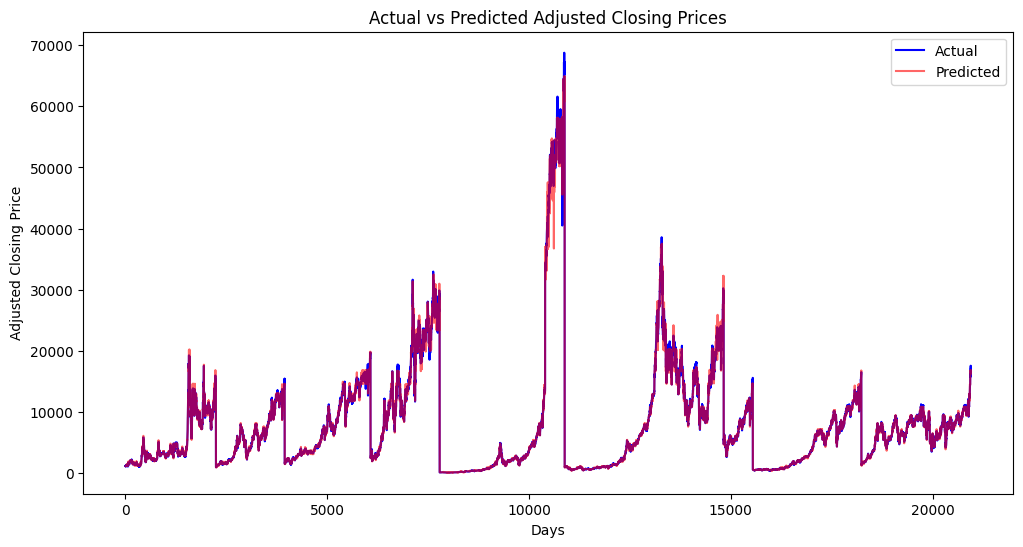

In [180]:
# Plot the actual vs predicted values for adjusted closing prices
preds = predictions.select("Adj Close", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["Adj Close"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Adjusted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()

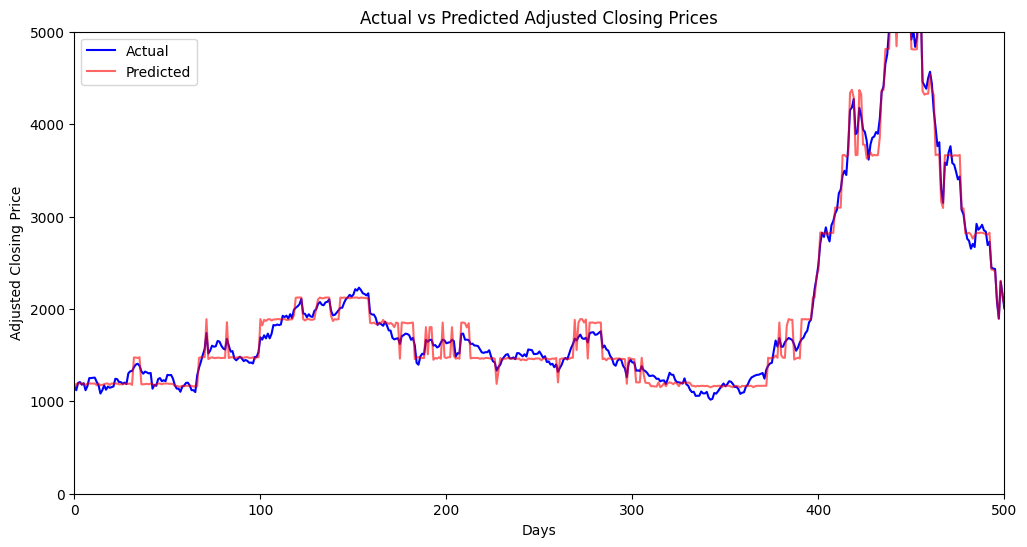

In [181]:
# Plot the actual vs predicted values for adjusted closing prices
preds = predictions.select("Adj Close", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["Adj Close"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Adjusted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Adjusted Closing Price')
plt.xlim(0, 500)
plt.ylim(0, 5000)
plt.legend()
plt.show()

In [182]:
# Define evaluator for MAE
evaluator_mae = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mae")
# Compute MAE
mae = evaluator_mae.evaluate(predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 231.04910032929314


In [183]:
# Define evaluator
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
# Compute RMSE
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 520.8677855080562


In [184]:
# Compute R2
evaluator_r2 = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2):", r2)

R-squared (R2): 0.9967784997813981
